In [1]:
import numpy as np
import sys

sys.path.append('../code/')

from mlalgos import Sequential,GAN
from mllib import Utilities,MLUtilities

from time import time
import pickle

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc

ut = Utilities()
ml = MLUtilities()

In [2]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14 # 14
mpl.rcParams['legend.labelspacing'] = 0.25
FS = 18
FS2 = 15
FS3 = 13
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

# Example usage of `GAN` (Generative Adversarial Network)

## Derivative test

#### Function definition

In [3]:
def func(x):
    return np.exp(-0.5*x**2)

def der(x):
    return -x*np.exp(-0.5*x**2)

X = ml.rv(np.linspace(-1.5,2,60))
Y = func(X)
dYdX = der(X)

#### Network setup and training

In [4]:
Train = False
start_time = time()
L = 5
params = {'data_dim':X.shape[0],'L':L,
          'n_layer':[300]*(L-1)+[Y.shape[0]],
          'atypes':['tanh']*(L-1)+['lin'],
          'loss_type':'square','file_stem':'gan/ddx_test'}
params_train = {'max_epoch':1000,'lrate':1e-4,'mb_count':6,'val_frac':0.2,'check_after':100}

net = Sequential(params)

if Train:
    net.train(X,Y,params_train)
    net.save()
else:
    net.load()

print('No. of params optimized = {0:d}'.format(net.calc_N_freeparams()))

ut.time_this(start_time)

... setting up 5 layer feed-forward neural network
... ... expecting data dim = 1, target dim = 1
... ... using hidden layers of sizes [300,300,300,300]
... ... ... and activations [tanh,tanh,tanh,tanh]
... ... using last activation layer 'lin'
... ... ... with threshold (None means default): None
... ... using loss function 'square'
... ... not using any regularization
... ... not using any weight decay
No. of params optimized = 271801
0 min 0.03 seconds



#### Plot

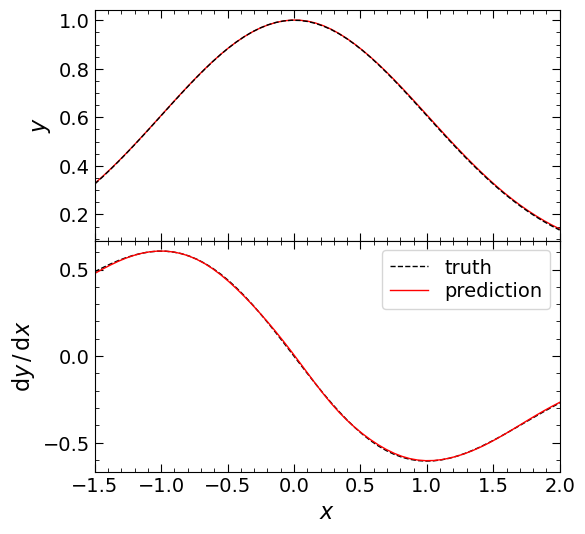

In [5]:
plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(2,1,height_ratios=[1,1],hspace=0)
ax1 = plt.subplot(gs[0])
ax1.set_xlim(X.min(),X.max())
ax1.set_xticklabels('')
ax1.set_ylabel('$y$')
ax1.plot(X[0],net.predict(X)[0],'r-',lw=1,label='prediction')
ax1.plot(X[0],Y[0],'k--',lw=1,label='truth')
ax1.minorticks_on()

ax2 = plt.subplot(gs[1])
ax2.set_xlim(X.min(),X.max())
ax2.set_xlabel('$x$')
ax2.set_ylabel('${\\rm d}y\\,/\\,{\\rm d}x$')
ax2.plot(X[0],dYdX[0],'k--',lw=1,label='truth')
ax2.plot(X[0],net.gradient(X)[0,0],'r-',lw=1,label='prediction')
ax2.legend(loc='upper right')
ax2.minorticks_on()

plt.show()

## GAN Test

#### Create input/target sample

In [6]:
Seed = 42
rng = np.random.RandomState(Seed)

n0 = 1 # input dimension
n_samp = 1000 # number of training samples
X = rng.randn(n0,n_samp)

#### Setup and train GAN
see also [this url](https://github.com/soumith/ganhacks)

In [7]:
Train = True

LG = 4
NNodes_G = 10
AType_G = 'relu'
Wt_Decay_G = 0.1

LD = 4
NNodes_D = 10
AType_D = 'relu'
Wt_Decay_D = 0.1

File_Stem = 'gan/test1d'

start_time = time()
params_setup = {'data_dim':n0,'file_stem':File_Stem,'seed':1983,
                'Lg':LG,'n_layer_g':[NNodes_G]*(LG-1)+[n0],'atypes_g':[AType_G]*(LG-1)+['lin'],'wt_decay_g':Wt_Decay_G,
                'Ld':LD,'n_layer_d':[NNodes_D]*(LD-1)+[1],'atypes_d':[AType_D]*(LD-1)+['sigm'],'wt_decay_d':Wt_Decay_D}

gan = GAN(params=params_setup)
if Train:
    params_train = {'max_epoch_d':2,'lrate_d':1e-3,
                    'max_epoch_g':8700,'lrate_g':1e-2,
                    'mb_size':None,'val_frac':0.0}#,'check_after':10}
    gan.train(X,params=params_train)
    gan.save()
else:
    gan.load()
    params_setup = gan.params

print('No. of params optimized = {0:d}'.format(gan.calc_N_freeparams()))

Z = gan.noise_prior(n0,n_samp)
X_Gen = gan.generate(Z)
ut.time_this(start_time)

Setting up GAN with 4-layer discriminator and 4-layer generator
... ** assumes uniform noise prior at present **
... ... expecting data dim = 1, output dim = 1
... ...  Gen using hidden layers of sizes [10,10,10,1]
... ... ... and activations [relu,relu,relu,lin]
... ... Disc using hidden layers of sizes [10,10,10,1]
... ... ... and activations [relu,relu,relu,sigm]
... ... using GAN loss function
... ... not using any regularization
... ...  Gen using weight decay with coefficient 1.0e-01 and norm 2
... ... Disc using weight decay with coefficient 1.0e-01 and norm 2
... setup complete
... training
... no mb_size specified. Setting to n_samp // 2.
[....................] 100% done
... ... done
No. of params optimized = 502
0 min 9.95 seconds



#### Plot

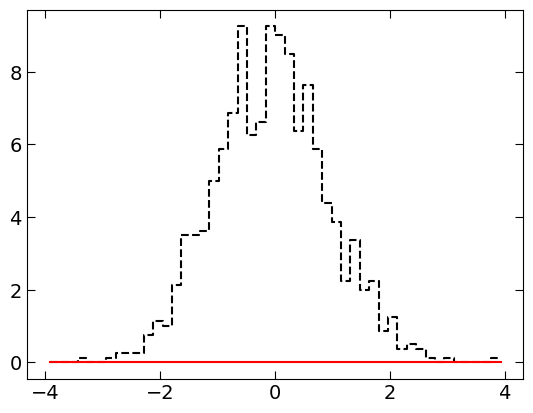

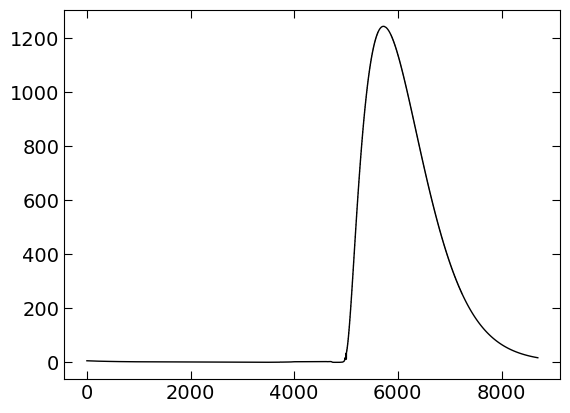

In [8]:
xbin = np.linspace(-4,4,50)
xmid = 0.5*(xbin[1:]+xbin[:-1])
dx = xmid[1] - xmid[0]
hist_target,dummy = np.histogram(X[0],bins=xbin) 
hist_target = hist_target/dx/xmid.size

hist_gen,dummy = np.histogram(X_Gen[0],bins=xbin) 
hist_gen = hist_gen/dx/xmid.size

plt.plot(xmid,hist_target,'k--',drawstyle='steps')
plt.plot(xmid,hist_gen,'r-',drawstyle='steps')
plt.show()

if Train:
    # plt.plot(gan.epochs,gan.val_loss,'r-',lw=1)
    plt.plot(gan.epochs_all/params_train['max_epoch_d'],gan.epoch_loss,'k-',lw=1)

In [9]:
X[:,:10],gan.discriminate(X[:,:10]),gan.discriminate(X_Gen[:,:10]),X_Gen[0,:10],Z[0,:10]

(array([[ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
         -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004]]),
 array([[0.49322402, 0.49320827, 0.49322783, 0.49325512, 0.49320712,
         0.49320712, 0.49325962, 0.49323084, 0.49320429, 0.49322518]]),
 array([[0.50666509, 0.50666509, 0.50666509, 0.50666509, 0.50666509,
         0.50666509, 0.50666509, 0.50666509, 0.50666509, 0.50666509]]),
 array([37702.93620575, 38009.22080271, 37700.4906372 , 37189.08255753,
        37124.77209551, 37946.46128165, 37790.06444126, 38192.27112345,
        37115.81227827, 37349.67120626]),
 array([0.66048542, 0.8614467 , 0.65888082, 0.3233327 , 0.28113693,
        0.82026855, 0.71765252, 0.98155077, 0.27525816, 0.42869908]))